In [1]:
import numpy as np
import matplotlib.pyplot  as plt
plt.style.use('../../../nico_general.mplstyle')

In [2]:
from sklearn.metrics import mean_squared_error as MSE
from scipy import optimize as scop

In [3]:
from numba import njit

@njit
def euler_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = x[i-1] + (y[i-1] - x[i-1]) * c

        
@njit
def rush_larsen_easy_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = y[i-1] + (x[i-1] - y[i-1]) * np.exp(c)
        
@njit
def rush_larsen_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = y[i-1] + (x[i-1] - y[i-1]) * np.exp(c[i-1])
        
def calculate_I_out(x, *args):
        
    kwargs = args[-1]
    
    if kwargs.get('log_scale', False):
        x = np.exp(x)
        
    C_p, C_m, a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, R_m, R_p, g_max, g_leak = x

    v_list = kwargs['v_list']
    k_list = kwargs['k_list']
    
    t = kwargs['t']
    dt = t[1] - t[0]
    
    v_p = np.zeros_like(t)

    V_m_list = np.zeros_like(t)

    v_0_list = np.zeros_like(t)
    v_0_list[k_list] = 1
    v_0_list = np.cumsum(v_0_list)

    V_m_list = v_list[v_0_list.astype(int) + 1]

    v_p = np.zeros_like(t)
    v = np.zeros_like(v_p)
    v_p[0] = -80
    v[0] = -80
    
    rush_larsen_easy_numba_helper(v_p, V_m_list, -dt / (R_p * C_p))
    rush_larsen_easy_numba_helper(v, v_p, -dt / (R_m * C_m))

    
    alfa_m  = a0_m * np.exp(-delta_m * v / (-s_m))
    betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
    
    alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
    betta_h = b0_h * np.exp((1-delta_h) * v / s_h)
    
    tau_m = 1/(betta_m + alfa_m)
    tau_h = 1/(betta_h + alfa_h)
    #v_const = -80
    
    m_inf = 1/(1+betta_m/alfa_m)
    h_inf = 1/(1+betta_h/alfa_h)
    
    
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    
    rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
    rush_larsen_numba_helper(h, h_inf, -dt / tau_h)

    
    v_rev = 18

    i_c = 1e9 * C_m * np.diff(v) / dt
    i_p = 1e9 * C_p * np.diff(v_p) / dt

    i_c = np.concatenate([i_c, i_c[-1:]])
    i_p = np.concatenate([i_p, i_p[-1:]])

    i_leak = g_leak * v

    tau_z = 1e-12 * 5e8
    I_in =  g_max * h * (m**3) * (v - v_rev) + i_p + i_c + i_leak
    
    I_out = np.zeros_like(I_in)
    I_out[0] = I_in[0]
    euler_numba_helper(I_out, I_in, dt / tau_z)

    return I_out

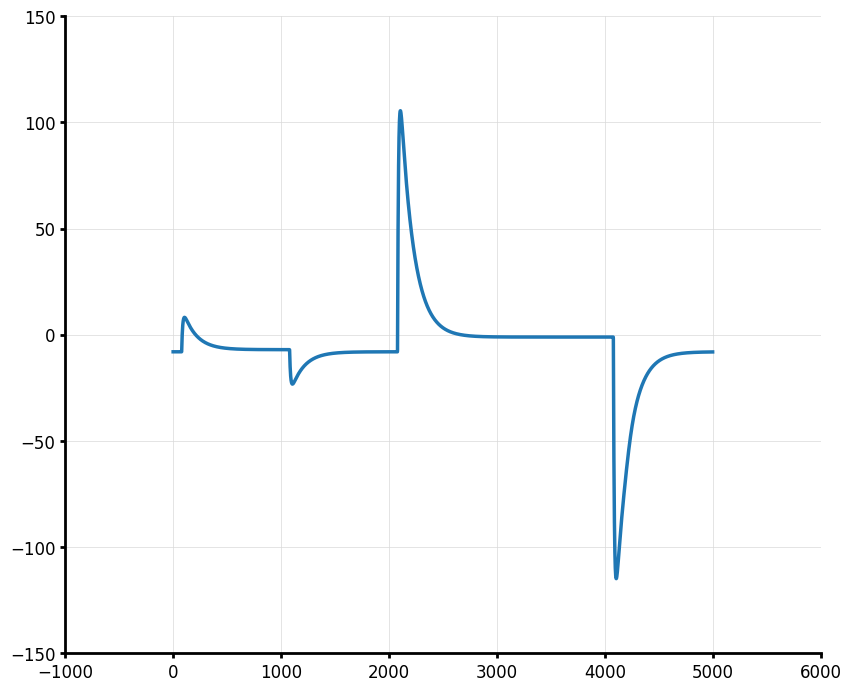

In [6]:
#         C_f     C     a0_m  b0_m  delta_m  s_m   a0_h  b0_h   delta_h  s_h      R    R_f   g_max  g_leak
x_true = [6e-15, 12e-12, 5e2,  80,     0.85,   6,     2,   4e4,    0.5,     6,    5e8,   5e6,   5e1,   1e-1]

x_true_log = np.log(x_true)

t = np.load('../data/time.npy')

v_list = np.array([-80, -80, -70, -80, -10, -80])
k_list = np.array([77, 1077, 2077, 4077]) + 1
dt = t[1] - t[0]

kwargs = dict(v_list = v_list,
              k_list = k_list,
              t = t,
              log_scale = True)

data = calculate_I_out(x_true_log, kwargs) # np.load('../data/simulated_func.npy')
plt.figure()
plt.plot(data)

In [7]:
def loss(x, *args):
    kwargs = args[-1]
    data = args[0]
    return MSE(data, calculate_I_out(x, *args))

In [8]:
%%timeit
loss(x_true_log, data, kwargs)

1.44 ms ± 96.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
x0 = x_true_log - 1
bounds = np.vstack([x_true_log  - 2, x_true_log + 2]).T

loss(x0, data, kwargs)

284.81551994076233

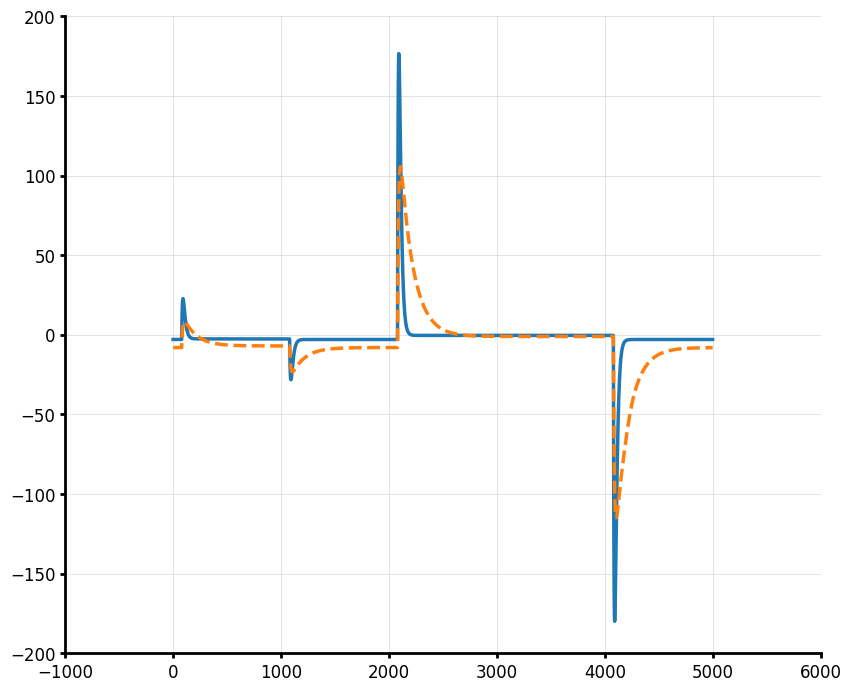

In [10]:
plt.plot(calculate_I_out(x0, kwargs))
plt.plot(data, '--')

### minimize

In [11]:
%%time
res = scop.minimize(loss, x0, bounds=bounds, args=(data, kwargs))

CPU times: user 227 ms, sys: 0 ns, total: 227 ms
Wall time: 236 ms


In [12]:
res.x

array([-33.79294973, -25.13301942,   5.16652376,   3.41866011,
        -1.14503678,   0.60279537,  -0.30714245,   9.61787277,
        -1.67465131,   0.87514137,  20.02339261,  14.42494847,
         2.89526313,  -2.29495836])

In [13]:
loss(res.x, data, kwargs)

0.11750388696556076

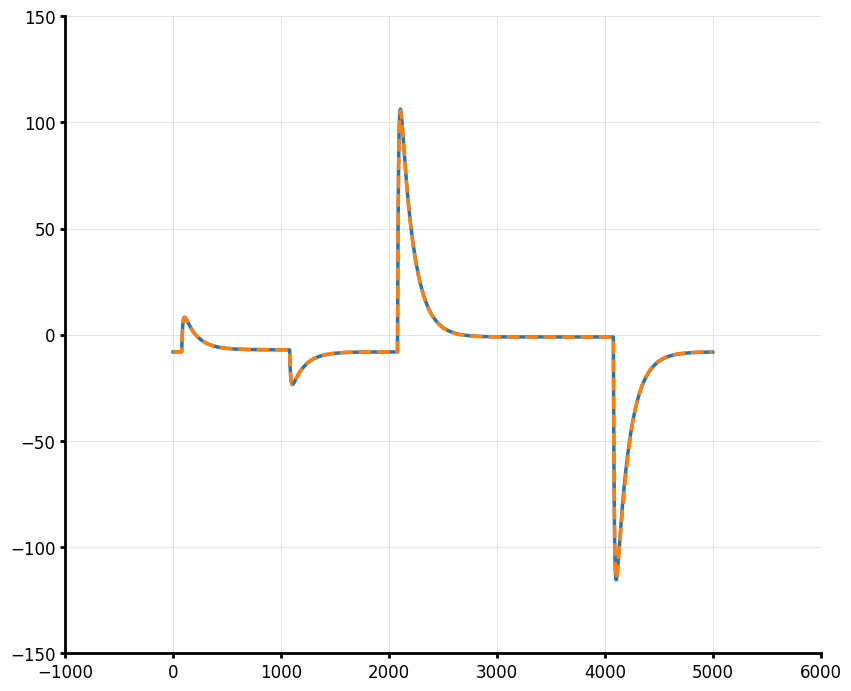

In [14]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(data, '--')

### differential_evolution

In [15]:
%%time
res = scop.differential_evolution(loss,
                                  bounds=bounds,
                                  args=(data, kwargs),
                                  maxiter=100, # I don't want to wait too long
                                  #disp=True,
                                  workers=-1)

/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py:495: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"


CPU times: user 4.35 s, sys: 429 ms, total: 4.78 s
Wall time: 17.4 s


In [16]:
res

     fun: 2.2804782115549053e-05
     jac: array([ 3.41103931e-05, -2.48111549e-05, -2.35995747e-06,  7.14536785e-05,
       -9.26979543e-06,  4.51369241e-05,  2.02001072e-05, -2.05021719e-05,
       -1.43580589e-06, -2.27998807e-06, -3.74663899e-05,  0.00000000e+00,
       -8.65564272e-06,  4.21784395e-06])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 22095
     nit: 100
 success: False
       x: array([-32.73608012, -25.14609008,   4.92495785,   4.86551114,
        -0.19208084,   2.41367629,   2.20009615,  11.090393  ,
         0.08135473,   1.89357536,  20.03014188,  15.56524884,
         4.81755036,  -2.30270377])

In [17]:
loss(res.x, data, kwargs)

2.2804782115549053e-05

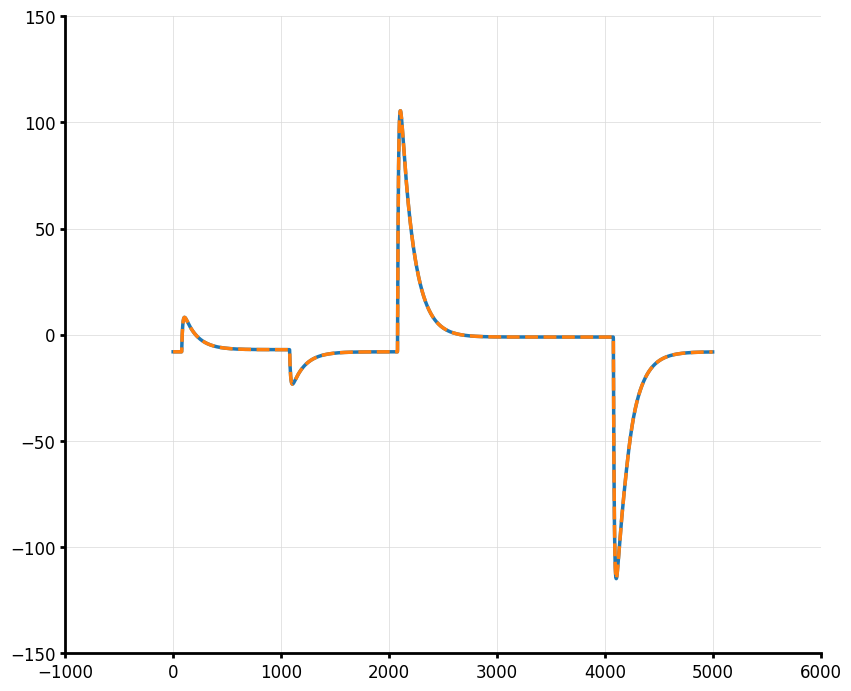

In [18]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(data, '--')

### dual_annealing

In [19]:
%%time
res = scop.dual_annealing(loss, bounds=bounds, x0 = x0, args=(data, kwargs))

CPU times: user 40.6 s, sys: 58.4 ms, total: 40.7 s
Wall time: 41.1 s


In [20]:
res

     fun: 5.697808934469397e-05
 message: ['Maximum number of iteration reached']
    nfev: 31856
    nhev: 0
     nit: 1000
    njev: 257
  status: 0
 success: True
       x: array([-32.76804296, -25.14612942,   5.81758646,   4.33585354,
        -0.11391615,   1.4913528 ,   0.53323149,   9.3615932 ,
         0.36290301,   1.93396082,  20.03006042,  14.52774661,
         4.83139448,  -2.30255931])

In [21]:
loss(res.x, data, kwargs)

5.697808934469397e-05

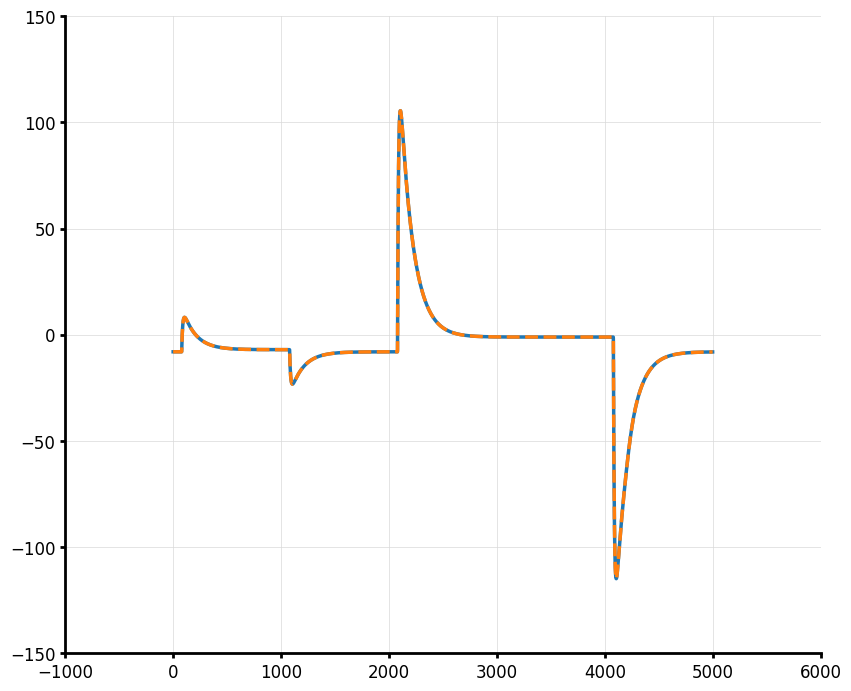

In [22]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(data, '--')